# Frequentist Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import pymc3 as pm
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import sklearn.metrics as metrics
import math as math

## 1) Creating a sample dataset that is a subset of my population to train my models on.

In [2]:
fraud = pd.read_csv('../data/creditcard.csv')

In [3]:
X_fraud = fraud.drop(columns=['Class'])
y_fraud = fraud['Class']

In [4]:
fraud_only = fraud[fraud["Class"] == 1]
non_fraud = fraud[fraud["Class"] == 0].sample(n=50000)

In [5]:
sample_fraud = pd.concat([fraud_only, non_fraud])
X_30 = sample_fraud.drop(columns=['Class'])
y_30 = sample_fraud['Class']

### Using SMOTE to oversample the minority class and undersample the majority class.

In [6]:
sm_30 = SMOTE(sampling_strategy= 1, kind ='regular', random_state=2019)
X_sample, y_sample = sm_30.fit_sample(X_30, y_30.ravel())

## 2) Using Logistic Regression to predict instances of fraud.

#### Printing out my coefficients as odds as well as my accuracy, recall and f1 score to compare against other models.

In [7]:
#https://stackoverflow.com/questions/34649969/how-to-find-the-features-names-of-the-coefficients-using-scikit-linear-regressio
pipe_log = Pipeline([
    ('sc', StandardScaler()),
    ('lr', LogisticRegression(multi_class='ovr'))
])
pipe_params_log = {
    'lr__solver': ['liblinear', 'sag', 'saga'],
    'lr__multi_class': ['ovr'],
    'lr__C': [.1, 1, 10],
    
}

gs_log = GridSearchCV(pipe_log, pipe_params_log, scoring='f1', n_jobs=-1);
#Fit the model with the count vectorizer using the training data
gs_log.fit(X_sample, y_sample)

classifier = gs_log.best_estimator_.named_steps['lr']
coefficients = classifier.coef_
coefficients = coefficients.tolist()[0]
coefficients = [math.exp(i) for i in coefficients]
coef_dict = {}
for coef, feat in zip(coefficients, X_fraud.columns):
    coef_dict[feat] = coef
print('The coefficients are: ', coef_dict)

print('The best parameters are: ', gs_log.best_params_)

pred = gs_log.predict(X_fraud)

print('The accuracy score is: ', accuracy_score(y_fraud, pred))

print('The recall score is: ', recall_score(y_fraud, pred))

print(confusion_matrix(y_fraud, pred))

print('The f1 score is: ', f1_score(y_fraud, pred));

/anaconda3/envs/DSI/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


The coefficients are:  {'Time': 0.6082632060262527, 'V1': 2690.3349568766034, 'V2': 65.74424925481595, 'V3': 94.5546635380279, 'V4': 13.823449037793733, 'V5': 383.07084865660744, 'V6': 0.22644230691258446, 'V7': 0.0006517889055695457, 'V8': 0.055346757338990506, 'V9': 0.2764624059995222, 'V10': 0.004621618737798914, 'V11': 14.291347563272703, 'V12': 0.00022482074788902, 'V13': 0.5998312266533327, 'V14': 2.0181920209722368e-05, 'V15': 0.8190580808645971, 'V16': 0.019938096744240758, 'V17': 6.442529107049411e-06, 'V18': 0.14460308781067577, 'V19': 2.429419284536447, 'V20': 0.24589149284891393, 'V21': 1.059953573770324, 'V22': 3.1378346619739474, 'V23': 3.569381609694835, 'V24': 1.059321670083415, 'V25': 1.0375540334660327, 'V26': 0.9495908157437289, 'V27': 1.2172874411612455, 'V28': 2.2299073535313156, 'Amount': 28.876554182742854}
The best parameters are:  {'lr__C': 10, 'lr__multi_class': 'ovr', 'lr__solver': 'liblinear'}
The accuracy score is:  0.9910044345820151
The recall score is:  

### Logistic Regression ROC Curve

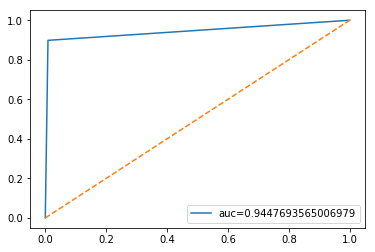

In [8]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = metrics.roc_curve(y_fraud,  pred)
auc = metrics.roc_auc_score(y_fraud, pred)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## 3) Using Random Forest Classification to predict instances of fraud.

In [9]:
pipe_rand_for = Pipeline([
    ('sc', StandardScaler()),
    ('rand_for', RandomForestClassifier())
])
pipe_params_rand_for = {
    'rand_for__n_estimators': [25, 150, 300],
    'rand_for__max_features': ['sqrt', 'log2']  
}

gs_rand_for = GridSearchCV(pipe_rand_for, pipe_params_rand_for, scoring='recall');
#Fit the model with the count vectorizer using the training data
gs_rand_for.fit(X_sample, y_sample)

print(gs_rand_for.best_params_)

pred_rand_for = gs_rand_for.predict(X_fraud)

print('The accuracy score is: ', accuracy_score(y_fraud, pred_rand_for))

print('The recall score is: ', recall_score(y_fraud, pred_rand_for))

print(confusion_matrix(y_fraud, pred_rand_for))

print('The f1 score is: ', f1_score(y_fraud, pred_rand_for));

/anaconda3/envs/DSI/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'rand_for__max_features': 'log2', 'rand_for__n_estimators': 300}
The accuracy score is:  0.99942417145646
The recall score is:  1.0
[[284151    164]
 [     0    492]]
The f1 score is:  0.8571428571428571


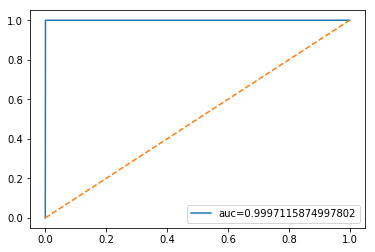

In [10]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = metrics.roc_curve(y_fraud,  pred_rand_for)
auc = metrics.roc_auc_score(y_fraud, pred_rand_for)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## 4) Using Gradient Boosting Classifier to predict instances of fraud.

In [11]:
pipe_gr_bo = Pipeline([
    ('sc', StandardScaler()),
    ('gr_bo', GradientBoostingClassifier(max_features='sqrt'))
])
pipe_params_gr_bo = {
    'gr_bo__loss': ['exponential'],
    'gr_bo__learning_rate': [1],
    'gr_bo__n_estimators': [500, 750],
    'gr_bo__min_samples_split': [2, 4, 6]
}

gs_gr_bo = GridSearchCV(pipe_gr_bo, pipe_params_gr_bo, scoring='recall', n_jobs=-1);
#Fit the model with the count vectorizer using the training data
gs_gr_bo.fit(X_sample, y_sample)

print(gs_gr_bo.best_params_)

pred_gr_bo = gs_gr_bo.predict(X_fraud)

print('The accuracy score is: ', accuracy_score(y_fraud, pred_gr_bo))

print('The recall score is: ', recall_score(y_fraud, pred_gr_bo))

print(confusion_matrix(y_fraud, pred_gr_bo))

print('The f1 score is: ', f1_score(y_fraud, pred_gr_bo));

/anaconda3/envs/DSI/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'gr_bo__learning_rate': 1, 'gr_bo__loss': 'exponential', 'gr_bo__min_samples_split': 2, 'gr_bo__n_estimators': 750}
The accuracy score is:  0.9990414561439852
The recall score is:  1.0
[[284042    273]
 [     0    492]]
The f1 score is:  0.7828162291169452


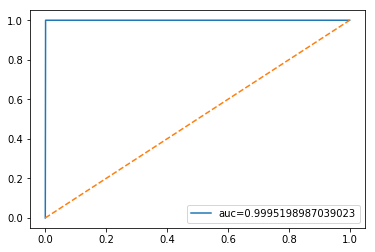

In [12]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = metrics.roc_curve(y_fraud,  pred_gr_bo)
auc = metrics.roc_auc_score(y_fraud, pred_gr_bo)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## 5) Using Extreme Gradient Boost Classifier to predict instances of fraud.

In [13]:
pipe_xg = Pipeline([
    ('sc', StandardScaler()),
    ('xb', XGBClassifier())
])
pipe_params_xg = {
    'xb__max_depth': [6, 9],
    'xb__learning_rate': [.4, .9],
    'xb__n_estimators': [500, 750],
    'xb__booster': ['gbtree']
}

gs_xg = GridSearchCV(pipe_xg, pipe_params_xg, scoring='recall', n_jobs=-1);
#Fit the model with the count vectorizer using the training data
gs_xg.fit(X_sample, y_sample)

print(gs_xg.best_params_)

pred_xg = gs_xg.predict(X_fraud)

print('The accuracy score is: ', accuracy_score(y_fraud, pred_xg))

print('The recall score is: ', recall_score(y_fraud, pred_xg))

print(confusion_matrix(y_fraud, pred_xg))

print('The f1 score is: ', f1_score(y_fraud, pred_xg));

/anaconda3/envs/DSI/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'xb__booster': 'gbtree', 'xb__learning_rate': 0.4, 'xb__max_depth': 6, 'xb__n_estimators': 750}
The accuracy score is:  0.9993609707626568
The recall score is:  1.0
[[284133    182]
 [     0    492]]
The f1 score is:  0.8439108061749571


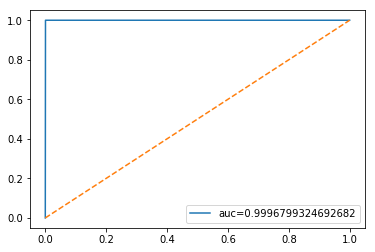

In [14]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = metrics.roc_curve(y_fraud,  pred_xg)
auc = metrics.roc_auc_score(y_fraud, pred_xg)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## 6) Using K-Nearest Neighbors Classifier to predict instances of fraud.

In [15]:
pipe_knn = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
pipe_params_knn = {
    'knn__n_neighbors': [5],
    'knn__weights': ['uniform'],
    'knn__p': [1],
    'knn__algorithm': ['kd_tree']
}

gs_knn = GridSearchCV(pipe_knn, pipe_params_knn, scoring='recall', n_jobs=-1);
gs_knn.fit(X_sample, y_sample)

print(gs_knn.best_params_)

pred_knn = gs_knn.predict(X_fraud)

print('The accuracy score is: ', accuracy_score(y_fraud, pred_knn))

print('The recall score is: ', recall_score(y_fraud, pred_knn))

print(confusion_matrix(y_fraud, pred_knn))

print('The f1 score is: ', f1_score(y_fraud, pred_knn));

/anaconda3/envs/DSI/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'knn__algorithm': 'kd_tree', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
The accuracy score is:  0.99539337165168
The recall score is:  1.0
[[283003   1312]
 [     0    492]]
The f1 score is:  0.42857142857142855


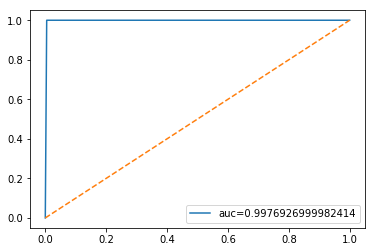

In [16]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = metrics.roc_curve(y_fraud,  pred_knn)
auc = metrics.roc_auc_score(y_fraud, pred_knn)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## 7) Using Support Vector Machines to predict instances of fraud.

In [17]:
pipe_svc = Pipeline([
    ('sc', StandardScaler()),
    ('svc', SVC())
])
pipe_params_svc = {
    'svc__kernel': ['linear'],
    'svc__C': [3, 5],
    'svc__gamma': ['scale']
}

gs_svc = GridSearchCV(pipe_svc, pipe_params_svc, scoring='recall', n_jobs=-1);
gs_svc.fit(X_sample, y_sample)

print(gs_svc.best_params_)

pred_svc = gs_svc.predict(X_fraud)

print('The accuracy score is: ', accuracy_score(y_fraud, pred_svc))

print('The recall score is: ', recall_score(y_fraud, pred_svc))

print(confusion_matrix(y_fraud, pred_svc))

print('The f1 score is: ', f1_score(y_fraud, pred_svc));

/anaconda3/envs/DSI/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'svc__C': 5, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
The accuracy score is:  0.9926968087160779
The recall score is:  0.8963414634146342
[[282286   2029]
 [    51    441]]
The f1 score is:  0.29777177582714387


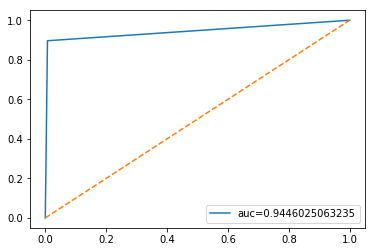

In [18]:
#https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, _ = metrics.roc_curve(y_fraud,  pred_svc)
auc = metrics.roc_auc_score(y_fraud, pred_svc)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

## 8) Using the unsupervised model K-Means to predict instances of fraud.

In [19]:
ss_sample = StandardScaler()
ss_fraud = StandardScaler()
X_sc_sample = ss_sample.fit_transform(X_sample)
X_sc_fraud = ss_fraud.fit_transform(X_fraud)

In [20]:
km = KMeans(n_clusters=70)
km.fit(X_sc_sample)
pred_km = km.predict(X_fraud)
print(pd.Series(pred_km).value_counts())

45    282461
43      1455
68       834
40        35
27        10
59         4
11         3
54         2
48         1
20         1
19         1
dtype: int64


In [21]:
kmeans_df = pd.DataFrame(data = [pred_km, y_fraud])
kmeans_df = kmeans_df.T
kmeans_df = kmeans_df.rename(columns={0: 'pred', 1: 'actual'})

In [22]:
kmeans_df.groupby(['pred']).count()

,actual
pred,
11,3
19,1
20,1
27,10
40,35
43,1455
45,282461
48,1
54,2


In [23]:
kmeans_df.groupby(['pred']).sum()

,actual
pred,
11,0
19,0
20,0
27,0
40,0
43,3
45,487
48,0
54,0
